# Loan Recommendation System 
### Approach - 2 
### Applicant Age and State
## POC - Proof Of Concept

<img src="./ClusteringSchema.png" />

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, rank, count #countDistinct
from pyspark.sql import functions as F
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors  ##DenseMatrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import operator
import time

In [2]:
spark = SparkSession.builder.appName('loan_recommendation_with_clusters').config("spark.driver.memory", "12g").getOrCreate()

In [3]:
# loans_df = spark.read.csv("RecommendData/df_temp_cluster_rating_condition_data.csv", inferSchema=True, header=True)
loans_df = spark.read.csv("Loan_Dataset/df_demographic_data_approach-2_v-5.csv", inferSchema=True, header=True)

loans_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- Cluster_result: integer (nullable = true)
 |-- Cluster_Group: integer (nullable = true)



In [4]:
loans_df.select(["Amount","Total_Repayments__c","Payment_Frequency__c","count","Cluster_Group"]).describe().show(10)

+-------+-----------------+-------------------+--------------------+------------------+------------------+
|summary|           Amount|Total_Repayments__c|Payment_Frequency__c|             count|     Cluster_Group|
+-------+-----------------+-------------------+--------------------+------------------+------------------+
|  count|           481006|             481006|              481006|            481006|            481006|
|   mean|861.6137844434373|  7.075683047612712|                NULL|1.6787087894953494| 33.69050905809907|
| stddev|809.0864163552588|   4.13665257694341|                NULL|0.8990843698676179|15.860555961145188|
|    min|              100|                  1|         Fortnightly|                 0|                 1|
|    max|             5000|                 45|              Weekly|                 8|                88|
+-------+-----------------+-------------------+--------------------+------------------+------------------+



In [78]:
loans_df.select(["summary_income","summary_income_cv"]).describe().show(10)

+-------+------------------+------------------+
|summary|    summary_income| summary_income_cv|
+-------+------------------+------------------+
|  count|            481006|            481006|
|   mean| 5685.780586499911|6108.1622303671475|
| stddev|252863.60798053938| 16676.18337996901|
|    min|               0.0|            -769.5|
|    max|     8.714009417E7|         8228670.0|
+-------+------------------+------------------+



* Id: Likely a unique identifier for each data point.
* AccountID: Unique identifier for an account (possibly borrower).
* Loan-related features: 
    1. Number_Of_Loans_Granted__c: Number of loans granted to the account.
    2. Num_Of_Loans_Paid__c: Number of loans paid by the account.
    3. Purpose_of_Loan__c: Category of the loan purpose (e.g., mortgage, education).
    4. Total_Repayments__c: Total amount repaid by the account.
    5. Amount: Loan amount requested.
    6. Term_in_Weeks__c: Loan term in weeks.
    7. Payment_Frequency__c: Frequency of loan repayment (e.g., weekly, monthly).
* Borrower-related features:
    1. StageName: Current stage of the loan application (e.g., application, approved, rejected).    
    2. Applicant Age: Age of the loan applicant    
    3. summary_income: Summary of applicant's incom    
    4. summary_income_cv: Coefficient of variation of applicant's income
    5. Location-related features:
    6. city: City of the applicant.
    7. state: State of the applicant.
    8. Country: Country of the applicant
* Additional features:
    1. userId: Unique identifier for a user Account Id in Numeric).     
    2. loanId: Unique identifier for a lo (Id or loanId in Numeric)
    3. counFeature related to the Ratings of the Loans.
    4. LoanIdFormat: Format of the loan(Created LoanId using Clusters).

In [5]:
loans_df.select(["Cluster_Group","Cluster_result","Amount","Total_Repayments__c","Payment_Frequency__c","count"]).show(10)

+-------------+--------------+------+-------------------+--------------------+-----+
|Cluster_Group|Cluster_result|Amount|Total_Repayments__c|Payment_Frequency__c|count|
+-------------+--------------+------+-------------------+--------------------+-----+
|            1|             1|   100|                  3|         Fortnightly|    1|
|            1|             1|   100|                  3|         Fortnightly|    1|
|            1|             1|   150|                 10|              Weekly|    1|
|            1|             1|   100|                  3|         Fortnightly|    1|
|            1|             2|   200|                  5|         Fortnightly|    1|
|            1|             2|   200|                  5|         Fortnightly|    1|
|            1|             2|   200|                  5|         Fortnightly|    1|
|            1|             2|   200|                  6|              Weekly|    1|
|            1|             2|   200|                  5|        

### Aggregating the loans per user (getting all loans for each user user)

In [6]:
user_loans = loans_df.groupby("userId").agg(F.collect_set("Cluster_result").alias("loans"))

In [7]:
Actual_loans_taken = user_loans.toPandas().to_dict('records')

### EDA - Exploratory Data Analysis 

<img src="https://editor.analyticsvidhya.com/uploads/24537Zoom-EDA.png" height=500 width="500" />

In [8]:
loans_df.select(["Cluster_Group","userId","Cluster_result","count","Amount","Number_Of_Loans_Granted__c","Num_Of_Loans_Paid__c"]).describe().show()

+-------+------------------+------------------+------------------+------------------+-----------------+--------------------------+--------------------+
|summary|     Cluster_Group|            userId|    Cluster_result|             count|           Amount|Number_Of_Loans_Granted__c|Num_Of_Loans_Paid__c|
+-------+------------------+------------------+------------------+------------------+-----------------+--------------------------+--------------------+
|  count|            481006|            481006|            481006|            481006|           481006|                    481006|              481006|
|   mean| 33.69050905809907| 24325.14109387409|11.569057350635958|1.6787087894953494|861.6137844434373|         11.97594832496892|  11.937333422036316|
| stddev|15.860555961145188|15296.967890708223| 8.303411728823416|0.8990843698676179|809.0864163552588|         8.181301138039649|   8.304372921673831|
|    min|                 1|                 1|                 1|                 0|   

#### Plotting the Frequnecy of Count(Ratings)

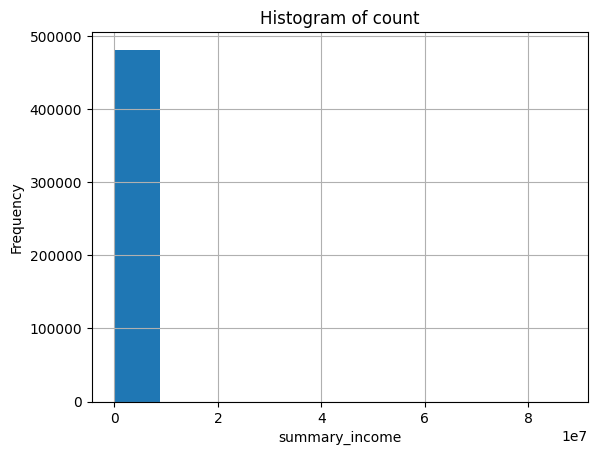

In [79]:
hist_data['summary_income'].hist()
plt.xlabel("summary_income")
plt.ylabel("Frequency")
plt.title(f"Histogram of count")
plt.show()

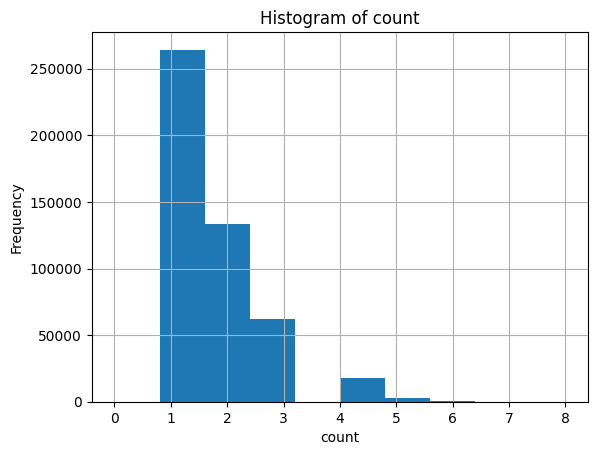

In [9]:
hist_data  = loans_df.toPandas()

hist_data['count'].hist()
plt.xlabel("count")
plt.ylabel("Frequency")
plt.title(f"Histogram of count")
plt.show()

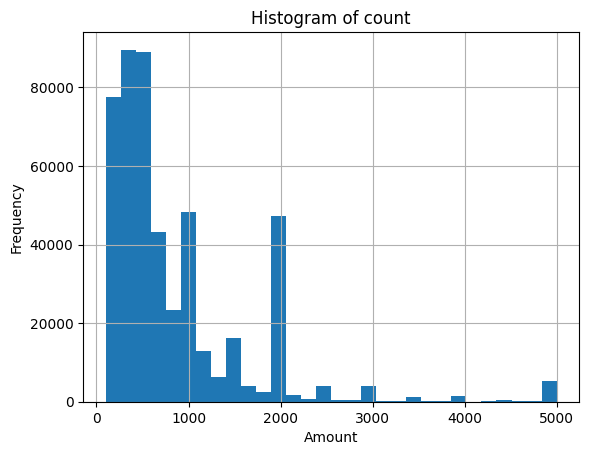

In [10]:
hist_data['Amount'].hist(bins=30)
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.title(f"Histogram of count")
plt.show()

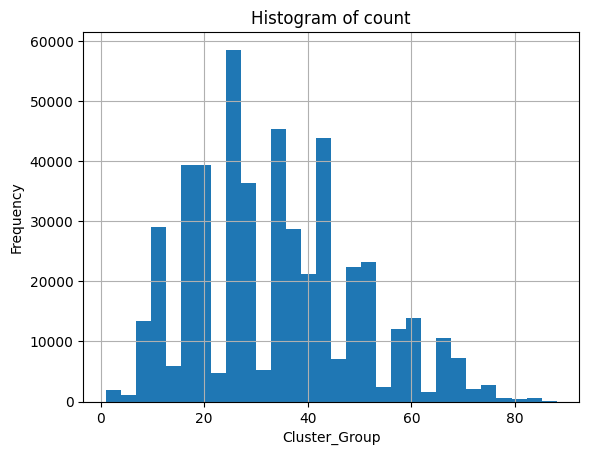

In [11]:
hist_data['Cluster_Group'].hist(bins=30)
plt.xlabel("Cluster_Group")
plt.ylabel("Frequency")
plt.title(f"Histogram of count")
plt.show()

#### Counting the No. of user & No. of Loans & No. of Explicitely Created Loan Id (Clustered Loan Id's)

In [12]:
# Count the number of unique items
num_unique_loan_id_format = loans_df.select('Cluster_result').distinct().count()
print(f"Number of unique loanId_format: {num_unique_loan_id_format}")

# Count the number of unique users
num_unique_id = loans_df.select('Id').distinct().count()
print(f"Number of unique Loan Id: {num_unique_id}")

Number of unique loanId_format: 38
Number of unique Loan Id: 407324


In [13]:
# Count the number of unique items
tmp = loans_df.select('userId').distinct().count()
print(f"Number of unique users: {tmp}")

Number of unique users: 59150


In [14]:
# creating a temporary view of 
# Dataframe and storing it into df2
loans_df.createOrReplaceTempView("df2")

In [15]:
# User Groups and their respective counts counts

In [16]:
 
# using the SQL query to count all
# distinct records and display the
# count on the screen
spark.sql("SELECT Cluster_Group, COUNT(*) AS count FROM df2 GROUP BY Cluster_Group").show()

+-------------+-----+
|Cluster_Group|count|
+-------------+-----+
|           12|13080|
|            1|  823|
|           13| 3856|
|            6|   74|
|           16| 1140|
|            3|  543|
|           20|23374|
|            5|  301|
|           19|10181|
|           15| 1227|
|            9|13192|
|           17|21920|
|            4|  692|
|            8|   69|
|            7|  147|
|           10| 8602|
|           21| 5725|
|           11| 7295|
|           14|  892|
|            2|  638|
+-------------+-----+
only showing top 20 rows



In [17]:
loans_df.select("Cluster_Group").describe().show()

+-------+------------------+
|summary|     Cluster_Group|
+-------+------------------+
|  count|            481006|
|   mean| 33.69050905809907|
| stddev|15.860555961145188|
|    min|                 1|
|    max|                88|
+-------+------------------+



In [18]:
spark.sql("SELECT count, COUNT(*) AS count FROM df2 GROUP BY count").show()

+-----+------+
|count| count|
+-----+------+
|    1|264313|
|    6|   523|
|    3| 61952|
|    5|  2910|
|    4| 17975|
|    2|133130|
|    0|     6|
|    7|   124|
|    8|    73|
+-----+------+



In [19]:
spark.sql("SELECT Cluster_result, COUNT(*) AS count FROM df2 GROUP BY Cluster_result").show()

+--------------+-----+
|Cluster_result|count|
+--------------+-----+
|            31|  260|
|            34|  191|
|            28|  261|
|            26| 2775|
|            27| 3691|
|            12|14659|
|            22| 3278|
|             1|  203|
|            13| 4990|
|             6|32680|
|            16|46307|
|             3|18546|
|            20| 4513|
|             5|13555|
|            19| 4206|
|            15| 8466|
|            37|  434|
|             9| 3556|
|            17| 3636|
|            35| 1480|
+--------------+-----+
only showing top 20 rows



#### Values of count(Rating) Column.

In [20]:
print('Distinct values of count:')
loans_df.select('count').distinct().orderBy("count").show()

Distinct values of count:
+-----+
|count|
+-----+
|    0|
|    1|
|    2|
|    3|
|    4|
|    5|
|    6|
|    7|
|    8|
+-----+



### Converting the dataset into train validation split.

In [21]:
# we have to use 3 columns or features to put into the ALs Model.
loans_df.select(["Cluster_result","count","Cluster_Group"]).show(10)

+--------------+-----+-------------+
|Cluster_result|count|Cluster_Group|
+--------------+-----+-------------+
|             1|    1|            1|
|             1|    1|            1|
|             1|    1|            1|
|             1|    1|            1|
|             2|    1|            1|
|             2|    1|            1|
|             2|    1|            1|
|             2|    1|            1|
|             2|    2|            1|
|             2|    2|            1|
+--------------+-----+-------------+
only showing top 10 rows



In [22]:
train, validation = loans_df.randomSplit([0.8, 0.2])
train.cache()
validation.cache()

DataFrame[Id: string, AccountID: string, Number_Of_Loans_Granted__c: int, Num_Of_Loans_Paid__c: int, Purpose_of_Loan__c: string, Total_Repayments__c: int, Amount: int, Term_in_Weeks__c: double, Payment_Frequency__c: string, StageName: string, Applicant Age: int, summary_income: double, summary_income_cv: double, city: string, state: string, Country: string, userId: int, loanId: int, count: int, Cluster_result: int, Cluster_Group: int]

In [23]:
validation.select(["Cluster_Group","userId","loanId","Cluster_result","count","Amount","Total_Repayments__c"]).show()

+-------------+------+------+--------------+-----+------+-------------------+
|Cluster_Group|userId|loanId|Cluster_result|count|Amount|Total_Repayments__c|
+-------------+------+------+--------------+-----+------+-------------------+
|           18| 23812|    41|             6|    2|   400|                 10|
|           17|   161|    50|             8|    1|   500|                  3|
|           17|   161|    50|             8|    1|   500|                  3|
|           18|   165|    54|             8|    1|   500|                 10|
|            9| 24489|   111|             6|    3|   400|                  2|
|           17| 24568|   117|             4|    4|   300|                  4|
|           20| 23462|   126|             8|    2|   500|                 10|
|           18| 24742|   157|             4|    1|   300|                  5|
|           17| 24806|   173|             6|    4|   400|                  2|
|           20|    59|   211|             2|    1|   200|       

In [24]:
loans_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- Cluster_result: integer (nullable = true)
 |-- Cluster_Group: integer (nullable = true)



In [25]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # Train the model using the training data
            als_model = ALS(maxIter=num_iters,regParam=reg, rank=rank,
                                        userCol='Cluster_Group', itemCol='Cluster_result', ratingCol='count', seed=99,
                           coldStartStrategy="drop",nonnegative=True)
            model = als_model.fit(train_data)

            # Generate predictions on the test data
            predictions = model.transform(validation_data)
            predictions = predictions.withColumn("prediction", expr("CASE WHEN prediction < 0 THEN 0 WHEN prediction > 9 THEN 9 ELSE prediction END"))

            evaluator = RegressionEvaluator(metricName='rmse', labelCol='count', predictionCol='prediction')
            error = evaluator.evaluate(predictions)

            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [26]:
# hyper-param config
num_iterations = 10
ranks = [8, 10, 20, 40, 60]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.001: validation RMSE is 0.8631948404549146
8 latent factors and regularization = 0.01: validation RMSE is 0.8630318870915092
8 latent factors and regularization = 0.05: validation RMSE is 0.8667718527858383
8 latent factors and regularization = 0.1: validation RMSE is 0.8719749979108091
8 latent factors and regularization = 0.2: validation RMSE is 0.8886664753601575
10 latent factors and regularization = 0.001: validation RMSE is 0.8623346969811225
10 latent factors and regularization = 0.01: validation RMSE is 0.8624050303639864
10 latent factors and regularization = 0.05: validation RMSE is 0.8676773747957697
10 latent factors and regularization = 0.1: validation RMSE is 0.8727421427726082
10 latent factors and regularization = 0.2: validation RMSE is 0.8887305739813294
20 latent factors and regularization = 0.001: validation RMSE is 0.861497327707438
20 latent factors and regularization = 0.01: validation RMSE is 0.8614989671082546
20 latent f

## Predicting the results from validation data

In [27]:
predictions = final_model.transform(validation)
# predictions = predictions.withColumn("prediction", expr("CASE WHEN prediction < 0 THEN 0 WHEN prediction > 9 THEN 9 ELSE prediction END"))

In [30]:
predictions.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- Cluster_result: integer (nullable = true)
 |-- Cluster_Group: integer (nullable = true)
 |-- prediction: float (nullable = false)



In [31]:
predictions.filter(predictions.userId == 10).select("Cluster_Group", "Cluster_result", "prediction").show(20)

+-------------+--------------+----------+
|Cluster_Group|Cluster_result|prediction|
+-------------+--------------+----------+
|           68|             2|  1.949957|
|           68|             6| 1.9977096|
|           68|             8| 2.0455227|
|           68|             8| 2.0455227|
|           68|             2|  1.949957|
+-------------+--------------+----------+



## Error Evaluation with RMSE

<img src="https://docs.oracle.com/en/cloud/saas/planning-budgeting-cloud/pfusu/img/insights_rmse_formula.jpg" height="300" width="300" />

In [32]:
# Evaluate the model using Root Mean Squared Error (RMSE)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="count", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) = " + str(rmse))

Root Mean Squared Error (RMSE) = 0.8610734089037843


## Recommendation of N users

In [33]:
userRecommends = final_model.recommendForAllUsers(5)
loanRecommends = final_model.recommendForAllItems(5)

In [34]:
userRecommends.printSchema()

root
 |-- Cluster_Group: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- Cluster_result: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [35]:
validation.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- Cluster_result: integer (nullable = true)
 |-- Cluster_Group: integer (nullable = true)



In [36]:
validation.count()

95939

## ALS Model Evaluation

In [37]:
# Assuming you have a DataFrame 'validation_data' containing the ground truth interactions
# and a DataFrame 'recommendations' containing the top-N recommendations generated by the ALS model

# Join recommendations with ground truth data to identify true positives
true_positives = predictions.join(validation, ['Cluster_Group', 'Cluster_result'], 'inner')

In [38]:
# Calculate the number of true positives per user
tp_per_user = true_positives.groupBy('Cluster_Group').agg(expr('count(Cluster_result) as true_positives'))

In [39]:
 # Calculate the total number of relevant items per user in the ground truth data
relevant_per_user = validation.groupBy('Cluster_Group').agg(expr('count(Cluster_result) as relevant'))

In [40]:
# Calculate Precision per user
precision_per_user = tp_per_user.join(relevant_per_user, 'Cluster_Group', 'inner') \
    .selectExpr('Cluster_Group', 'true_positives / relevant as precision')

In [41]:
# Calculate Recall per user
recall_per_user = tp_per_user.join(relevant_per_user, 'Cluster_Group', 'inner') \
    .selectExpr('Cluster_Group', 'true_positives / relevant as recall')

In [42]:
# Calculate F1-score per user
f1_score_per_user = precision_per_user.join(recall_per_user, 'Cluster_Group', 'inner') \
    .selectExpr('Cluster_Group', '(2 * precision * recall) / (precision + recall) as f1_score')

In [43]:
# Calculate overall Precision, Recall, and F1-score
overall_precision = precision_per_user.agg({'precision': 'avg'}).collect()[0][0]
overall_recall = recall_per_user.agg({'recall': 'avg'}).collect()[0][0]
overall_f1_score = f1_score_per_user.agg({'f1_score': 'avg'}).collect()[0][0]


In [44]:

# Print the results
print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)
print("Overall F1-score:", overall_f1_score)


Overall Precision: 86.78013058179398
Overall Recall: 86.78013058179398
Overall F1-score: 86.780130581794


In [45]:
evaluator = RegressionEvaluator(metricName="mae", labelCol="count", predictionCol="prediction")
mae = evaluator.evaluate(predictions)

In [46]:
"The Mean Absolute Error is :",mae

('The Mean Absolute Error is :', 0.6835022909218127)

## User Factors and Item Factors to calculate the cosine Similarity

In [47]:
userFactors = final_model.userFactors
itemFactors = final_model.itemFactors

In [48]:
print(userFactors.count())
print("Priting the Schema of userFactors",userFactors.printSchema())

88
root
 |-- id: integer (nullable = false)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = false)

Priting the Schema of userFactors None


In [49]:

userFactors.filter(userFactors.id == 4 ).collect()

[Row(id=4, features=[0.09122948348522186, 0.0, 0.0, 0.0789027288556099, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12343259155750275, 0.0, 0.1793815791606903, 0.0, 0.0, 0.0, 0.0, 0.09000958502292633, 0.03921256959438324, 0.10617019236087799, 0.14351870119571686, 0.14229944348335266, 0.022420503199100494, 0.0, 0.04881124570965767, 0.0, 0.0, 0.0, 0.053601790219545364, 0.0, 0.3365114629268646, 0.0, 0.047878798097372055, 0.0, 0.0, 0.0522245392203331, 0.0, 0.0, 0.0, 0.08014018833637238, 0.0, 0.0, 0.02333768829703331, 0.0, 0.0, 0.1018809825181961, 0.17544867098331451, 0.0, 0.0, 0.029297584667801857, 0.03450474143028259, 0.0, 0.0, 0.020924124866724014, 0.0, 0.057687077671289444, 0.07058975100517273, 0.11131595820188522, 0.0, 0.0])]

In [50]:
userFactors.select("id","features").show(10,truncate=False)

+---+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |features                                                                                                                                                                                                                                                                                                                                                                                    

In [51]:
itemFactors.select("id","features").show(10,truncate=False)

+---+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |features                                                                                                                                                                                                                                                                                                                                                                                                      

## Calculate cosine similarity:

<img src="https://datascience103579984.files.wordpress.com/2020/01/13-12.png" height="600" width="600" />

In [52]:
def cosine_similarity(u1, u2):
    """Calculates cosine similarity between two user factors."""
    # Convert lists to DenseVectors before performing operations
    u1_vector = Vectors.dense(u1)
    u2_vector = Vectors.dense(u2)
    return u1_vector.dot(u2_vector) / (u1_vector.norm(p=2) * u2_vector.norm(p=2))

### user-User Cosine Similarity code

In [53]:
# Example usage
user1_id = 1
user2_id = 2
user1_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
user2_factors = userFactors.filter(userFactors.id == user2_id ).collect()[0][1]
# user1_factors = userFactors.to_dense().rdd.filter(lambda x: x[0] == user1_id).collect()[0][1]
# user2_factors = userFactors.to_dense().rdd.filter(lambda x: x[0] == user2_id).collect()[0][1]
similarity = cosine_similarity(user1_factors, user2_factors)
print(f"Cosine similarity between users {user1_id} and {user2_id}: {similarity}")


Cosine similarity between users 1 and 2: 0.8148279651352279


### User-Item Cosine Similarity code

In [54]:
# Example usage
user1_id = 1
item_id = 1
user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]

user_item_similarity = cosine_similarity(user_factors, item_factors)
print(f"Cosine similarity between users {user1_id} and {item_id}: {user_item_similarity}")

Cosine similarity between users 1 and 1: 0.794982544035211


###  Cosine Similarity of user 10 with all Loans

In [55]:
TopCosineLoanforuser10 = []
for item in range(itemFactors.count()):
    item_id = itemFactors.select("Id").sort("Id").take(itemFactors.count())[item][0]
    user1_id = 1
    user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
    item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]


    user_item_similarity = cosine_similarity(user_factors, item_factors)
    TopCosineLoanforuser10.append({"userID":user1_id,"LoanId":item_id,"CosineSimilarity":user_item_similarity})

In [56]:
sorted_Cosine_list = sorted(TopCosineLoanforuser10, key=operator.itemgetter('CosineSimilarity'),reverse=True)
sorted_Cosine_list

[{'userID': 1, 'LoanId': 1, 'CosineSimilarity': 0.794982544035211},
 {'userID': 1, 'LoanId': 25, 'CosineSimilarity': 0.7178857702406796},
 {'userID': 1, 'LoanId': 3, 'CosineSimilarity': 0.6929815267918324},
 {'userID': 1, 'LoanId': 2, 'CosineSimilarity': 0.6875448240047488},
 {'userID': 1, 'LoanId': 16, 'CosineSimilarity': 0.6874889420758632},
 {'userID': 1, 'LoanId': 38, 'CosineSimilarity': 0.6852612257590909},
 {'userID': 1, 'LoanId': 4, 'CosineSimilarity': 0.6800952460023181},
 {'userID': 1, 'LoanId': 12, 'CosineSimilarity': 0.676501394874476},
 {'userID': 1, 'LoanId': 24, 'CosineSimilarity': 0.6707029920688503},
 {'userID': 1, 'LoanId': 8, 'CosineSimilarity': 0.6689990888600865},
 {'userID': 1, 'LoanId': 30, 'CosineSimilarity': 0.6668485989771445},
 {'userID': 1, 'LoanId': 27, 'CosineSimilarity': 0.6623260793050937},
 {'userID': 1, 'LoanId': 5, 'CosineSimilarity': 0.6583754102135376},
 {'userID': 1, 'LoanId': 35, 'CosineSimilarity': 0.6509530370188448},
 {'userID': 1, 'LoanId': 14,

### Cosine Similarity of all users with all loans

In [57]:
# Collect all user factors into a dictionary
user_factors_dict = userFactors.select("id", "features").rdd.collectAsMap()

# Broadcast the user factors dictionary to all workers
broadcast_user_factors = spark.sparkContext.broadcast(user_factors_dict)

# Collect all item factors into a dictionary
item_factors_dict = itemFactors.select("id", "features").rdd.collectAsMap()

# Broadcast the item factors dictionary to all workers
broadcast_item_factors = spark.sparkContext.broadcast(item_factors_dict)

In [58]:
# Initially the code is like this !!
def cosine_similarity(u1, u2):
    """Calculates cosine similarity between two user group factors."""
    # Convert lists to DenseVectors before performing operations
    u1_vector = Vectors.dense(u1)
    u2_vector = Vectors.dense(u2)
    return u1_vector.dot(u2_vector) / (u1_vector.norm(p=2) * u2_vector.norm(p=2))

def cosine_similarity(vec1, vec2):
    dot_product = sum(v1 * v2 for v1, v2 in zip(vec1, vec2))
    magnitude1 = sum(v ** 2 for v in vec1) ** 0.5
    magnitude2 = sum(v ** 2 for v in vec2) ** 0.5
    return dot_product / (magnitude1 * magnitude2)

In [59]:


# Initialize list to store recommendations
CosineSilty_first10 = []
starttime = time.time()
Nusers = userFactors.select("id").count()

# Iterate over users
for userId in range(1, Nusers):
    user_factors = broadcast_user_factors.value.get(userId)
    if user_factors:
        TopCosineLoanforuser10 = []
        # Iterate over items
        for item_id, item_factors in broadcast_item_factors.value.items():
            user_item_similarity = cosine_similarity(user_factors, item_factors)
            TopCosineLoanforuser10.append({item_id: user_item_similarity})

        # Sort recommendations based on similarity
        Recomnd_loans = sorted(TopCosineLoanforuser10, key=lambda x: list(x.values())[0], reverse=True)
        CosineSilty_first10.append({"UserId": userId, "Recommendation": Recomnd_loans})

endtime = time.time()
runtime_hours = (endtime - starttime) / 3600
print(f"The time taken to run code for {Nusers} users is : {runtime_hours} hours")

The time taken to run code for 88 users is : 4.0341019630432126e-05 hours


In [60]:
# Define a function to extract top-N recommendations
def extract_top_n_recommendations(recommendations_data, n=2500):
    top_n_recommendations = [{'userId': user_recommendation['UserId'],
                              'Recommendation': [list(rec.keys())[0] for rec in user_recommendation['Recommendation'][:n]]}
                             for user_recommendation in recommendations_data]
    return top_n_recommendations

# Extract top-N recommendations
starttime = time.time()
top_n_recommendations = extract_top_n_recommendations(CosineSilty_first10, n=5)
endtime = time.time()
runtime_hours = (endtime - starttime) / 3600


In [61]:
top_n_recommendations

[{'userId': 1, 'Recommendation': [1, 25, 3, 2, 16]},
 {'userId': 2, 'Recommendation': [25, 1, 16, 24, 12]},
 {'userId': 3, 'Recommendation': [1, 25, 16, 2, 4]},
 {'userId': 4, 'Recommendation': [1, 22, 25, 16, 37]},
 {'userId': 5, 'Recommendation': [1, 25, 16, 2, 4]},
 {'userId': 6, 'Recommendation': [13, 9, 18, 11, 23]},
 {'userId': 7, 'Recommendation': [1, 25, 16, 27, 20]},
 {'userId': 8, 'Recommendation': [1, 25, 16, 2, 20]},
 {'userId': 9, 'Recommendation': [4, 1, 2, 3, 5]},
 {'userId': 10, 'Recommendation': [3, 2, 25, 1, 4]},
 {'userId': 11, 'Recommendation': [1, 25, 3, 2, 8]},
 {'userId': 12, 'Recommendation': [1, 3, 2, 4, 12]},
 {'userId': 13, 'Recommendation': [10, 25, 21, 9, 16]},
 {'userId': 14, 'Recommendation': [1, 3, 2, 4, 12]},
 {'userId': 15, 'Recommendation': [8, 25, 1, 4, 16]},
 {'userId': 16, 'Recommendation': [8, 25, 5, 1, 3]},
 {'userId': 17, 'Recommendation': [4, 2, 6, 25, 16]},
 {'userId': 18, 'Recommendation': [8, 24, 25, 6, 16]},
 {'userId': 19, 'Recommendation'

In [62]:
# Function to recommend top N loans not taken by the user
def recommend_loans_not_taken(user_id, recommendations, actual_loans_taken, top_n):
    taken_loans = set(actual_loans_taken.get(user_id, []))
    recommended_loans = []
    for rec in recommendations:
        loan_id = list(rec.keys())[0]
        if loan_id not in taken_loans:
            recommended_loans.append(loan_id)
            if len(recommended_loans) == top_n:
                break
    return recommended_loans

# Define a dictionary to store actual loans taken by each user
actual_loans_taken_dict = {record['userId']: record['loans'] for record in Actual_loans_taken}

# Create a list to store recommendations for each user
recommendations_for_users = []

# Iterate over each user
for rec_user in CosineSilty_first10:
    user_id = rec_user['UserId']
    recommendations = rec_user['Recommendation']
    # Recommend top N loans not taken by the user
    recommended_loans = recommend_loans_not_taken(user_id, recommendations, actual_loans_taken_dict, top_n=5)
    recommendations_for_users.append({'UserId': user_id, 'Recommendations': recommended_loans})



In [63]:
recommendations_for_users

[{'UserId': 1, 'Recommendations': [1, 25, 3, 2, 38]},
 {'UserId': 2, 'Recommendations': [1, 24, 12, 2, 3]},
 {'UserId': 3, 'Recommendations': [1, 16, 2, 3, 24]},
 {'UserId': 4, 'Recommendations': [1, 22, 25, 16, 37]},
 {'UserId': 5, 'Recommendations': [1, 25, 2, 4, 20]},
 {'UserId': 6, 'Recommendations': [13, 9, 18, 11, 23]},
 {'UserId': 7, 'Recommendations': [1, 27, 20, 30, 2]},
 {'UserId': 8, 'Recommendations': [1, 2, 10, 4, 3]},
 {'UserId': 9, 'Recommendations': [4, 1, 2, 3, 5]},
 {'UserId': 10, 'Recommendations': [1, 15, 16, 20, 27]},
 {'UserId': 11, 'Recommendations': [1, 25, 5, 13, 24]},
 {'UserId': 12, 'Recommendations': [1, 3, 4, 12, 25]},
 {'UserId': 13, 'Recommendations': [10, 21, 9, 16, 7]},
 {'UserId': 14, 'Recommendations': [1, 3, 2, 4, 12]},
 {'UserId': 15, 'Recommendations': [1, 16, 20, 32, 24]},
 {'UserId': 16, 'Recommendations': [5, 1, 3, 2, 6]},
 {'UserId': 17, 'Recommendations': [25, 24, 18, 17, 14]},
 {'UserId': 18, 'Recommendations': [24, 25, 16, 12, 14]},
 {'UserI

In [77]:
pd.DataFrame(recommendations_for_users).head().to_csv("Export_recommendations.csv",index=False)

In [75]:
actual_loans_taken_dict

{1: [15, 12, 30, 16, 24, 21, 18, 14, 8],
 2: [19, 16, 13, 5, 6, 18, 10, 25, 4, 8],
 3: [6, 10, 25, 4, 8],
 4: [2, 3, 4],
 5: [16, 6, 3, 10, 8],
 6: [12, 16, 8],
 7: [12, 16, 5, 6, 25],
 8: [15, 12, 16, 13, 20, 24, 21, 18, 25, 8],
 9: [6, 7],
 10: [12, 5, 2, 6, 3, 25, 4, 8],
 11: [15, 12, 16, 2, 17, 6, 3, 10, 4, 14, 8],
 12: [16, 2, 17, 6, 21, 14, 8],
 13: [2, 6, 25, 4, 8],
 14: [16, 24, 21, 10],
 15: [5, 2, 6, 3, 10, 25, 4, 8],
 16: [12, 16, 25, 8],
 17: [12, 16, 5, 2, 20, 6, 3, 10, 4, 11, 8],
 18: [2, 6, 8],
 19: [16, 2, 18, 10, 4, 14, 8],
 20: [8],
 21: [16, 5, 38, 24, 25, 22, 8, 26],
 22: [5, 6, 3],
 23: [5, 2],
 24: [16, 4, 14, 8],
 25: [12, 2, 18, 7, 4],
 26: [18, 10, 8],
 27: [5, 2, 6, 8],
 28: [5, 10, 14, 8],
 29: [2, 4],
 30: [25, 8],
 31: [30, 16, 24, 3, 18, 21, 10, 4, 14],
 32: [6, 25, 4, 8],
 33: [30, 16, 5, 4, 14],
 34: [15, 12, 19, 6, 3, 18, 24, 10, 7, 4, 14, 11, 8],
 35: [2, 4],
 36: [12, 16, 8],
 37: [38, 10, 25, 4, 11, 26, 13, 5, 20, 35, 6, 7, 14, 8, 23],
 38: [2, 6, 3,

In [65]:
userRecommends.select(["Cluster_Group","recommendations.Cluster_result","recommendations.rating"]).show(10,truncate=False)

+-------------+--------------------+-------------------------------------------------------+
|Cluster_Group|Cluster_result      |rating                                                 |
+-------------+--------------------+-------------------------------------------------------+
|20           |[7, 9, 34, 33, 38]  |[2.0712118, 1.9860481, 1.97451, 1.9600447, 1.870667]   |
|40           |[38, 34, 35, 36, 7] |[1.7941841, 1.7396492, 1.6642027, 1.6371219, 1.6335018]|
|10           |[37, 33, 28, 15, 3] |[1.7225457, 1.7011422, 1.4975848, 1.4507886, 1.4203078]|
|50           |[33, 17, 9, 15, 7]  |[2.6295927, 2.3879259, 2.3178267, 2.3129728, 2.2558866]|
|80           |[28, 34, 29, 32, 37]|[3.7012384, 2.9480135, 2.9159768, 2.8480837, 2.8039248]|
|70           |[9, 34, 28, 13, 37] |[2.9317381, 2.8367484, 2.6901827, 2.4784207, 2.4689398]|
|60           |[37, 15, 38, 24, 23]|[2.5307095, 2.3666756, 2.3566906, 2.3422809, 2.3393006]|
|30           |[38, 32, 34, 21, 23]|[1.817485, 1.6467685, 1.6357145, 1

In [66]:
actual = [listo for listo in actual_loans_taken_dict.values()]

In [67]:
predicted = [listo['Recommendation'] for listo in top_n_recommendations]

In [68]:
def average_precision_at_k(actual, predicted, k):
    # Initialize variables
    num_hits = 0
    precision_at_k = 0.0

    # Iterate over the predicted list up to k
    for i, p in enumerate(predicted[:k]):
        # Check if the predicted item at position i is in the actual list
        if p in actual:
            num_hits += 1
            # Calculate precision at position i
            precision_at_k += num_hits / (i + 1)

    # Calculate average precision at k
    if not actual:
        return 0.0
    else:
        return precision_at_k / min(len(actual), k)

def map_at_k(actual, predicted, k):
    # Calculate average precision at k for each query or user
    average_precisions = [average_precision_at_k(a, p, k) for a, p in zip(actual, predicted)]
    
    # Return the mean of average precision at k values
    return sum(average_precisions) / len(average_precisions)

In [69]:

k = 5
map_at_5 = map_at_k(actual, predicted, k)
print("MAP@{}: {:.4f}".format(k, map_at_5))

MAP@5: 0.1262


In [70]:
k = 3
map_at_3 = map_at_k(actual, predicted, k)
print("MAP@{}: {:.4f}".format(k, map_at_3))

MAP@3: 0.1450


In [71]:
userRecomd = userRecommends.select("recommendations.Cluster_result").collect() #.show(10,truncate=False)

In [72]:
ALsRecomd = [elemt.asDict()['Cluster_result'] for elemt in userRecomd]

In [73]:

k = 5
map_at_5 = map_at_k(actual, ALsRecomd, k)
print("MAP@{}: {:.4f}".format(k, map_at_5))

MAP@5: 0.0163


##  Calculate centered cosine similarity:

In [67]:
def centered_cosine_similarity(u, v):
    """ Calculate centered cosine similarity between two vectors u and v. """
    # Calculate mean of u and v
    mean_u = sum(u) / len(u)
    mean_v = sum(v) / len(v)

    # Subtract mean from u and v
    centered_u = Vectors.dense([x - mean_u for x in u])
    centered_v = Vectors.dense([x - mean_v for x in v])

    # Calculate centered cosine similarity
    dot_product = float(centered_u.dot(centered_v))
    norm_u = float(centered_u.norm(2))
    norm_v = float(centered_v.norm(2))

    centered_sim = dot_product / (norm_u * norm_v)
    return centered_sim


### User-User Centerd Cosine Similarity code

In [68]:
# Example usage
user1_id = 10
user2_id = 20
user1_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
user2_factors = userFactors.filter(userFactors.id == user2_id ).collect()[0][1]
similarity = centered_cosine_similarity(user1_factors, user2_factors)
print(f"Centered Cosine similarity between users {user1_id} and {user2_id}: {similarity}")


Centered Cosine similarity between users 10 and 20: 0.9958091259308894


### User-Item Centerd Cosine Similarity code

In [69]:
# Example usage
user1_id = 10
item_id = 1
user2_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
item3_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]

user_item_similarity = centered_cosine_similarity(user2_factors, item3_factors)
print(f"Centered Cosine similarity between users {user1_id} and Item {item_id}: {user_item_similarity}")


Centered Cosine similarity between users 10 and Item 1: 0.9846653141373279


### Centered Cosine Similarity of user 10 with all Loans

In [70]:
topNLoanforuser10 = []
for item in range(itemFactors.count()):
    item_id = itemFactors.select("Id").sort("Id").take(itemFactors.count())[item][0]
    user1_id = 10
    user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
    item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]


    user_item_similarity = centered_cosine_similarity(user_factors, item_factors)
    topNLoanforuser10.append({"userID":user1_id,"LoanId":item_id,"CenteredSimilarity":user_item_similarity})

In [71]:
sorted_list = sorted(topNLoanforuser10, key=operator.itemgetter('CenteredSimilarity'),reverse=True)
sorted_list

[{'userID': 10, 'LoanId': 3, 'CenteredSimilarity': 0.9999751517477451},
 {'userID': 10, 'LoanId': 4, 'CenteredSimilarity': 0.9996252399081585},
 {'userID': 10, 'LoanId': 5, 'CenteredSimilarity': 0.9993524436452954},
 {'userID': 10, 'LoanId': 2, 'CenteredSimilarity': 0.9993435123150312},
 {'userID': 10, 'LoanId': 7, 'CenteredSimilarity': 0.9968689838562832},
 {'userID': 10, 'LoanId': 6, 'CenteredSimilarity': 0.9961854650889006},
 {'userID': 10, 'LoanId': 8, 'CenteredSimilarity': 0.9958091262067013},
 {'userID': 10, 'LoanId': 9, 'CenteredSimilarity': 0.9921921103738105},
 {'userID': 10, 'LoanId': 25, 'CenteredSimilarity': 0.9883251622950934},
 {'userID': 10, 'LoanId': 11, 'CenteredSimilarity': 0.9872106949357707},
 {'userID': 10, 'LoanId': 10, 'CenteredSimilarity': 0.9860440617410834},
 {'userID': 10, 'LoanId': 12, 'CenteredSimilarity': 0.9850307062957183},
 {'userID': 10, 'LoanId': 1, 'CenteredSimilarity': 0.9846653141373279},
 {'userID': 10, 'LoanId': 14, 'CenteredSimilarity': 0.981785

In [72]:
sorted(topNLoanforuser10, key=operator.itemgetter('LoanId') )

[{'userID': 10, 'LoanId': 1, 'CenteredSimilarity': 0.9846653141373279},
 {'userID': 10, 'LoanId': 2, 'CenteredSimilarity': 0.9993435123150312},
 {'userID': 10, 'LoanId': 3, 'CenteredSimilarity': 0.9999751517477451},
 {'userID': 10, 'LoanId': 4, 'CenteredSimilarity': 0.9996252399081585},
 {'userID': 10, 'LoanId': 5, 'CenteredSimilarity': 0.9993524436452954},
 {'userID': 10, 'LoanId': 6, 'CenteredSimilarity': 0.9961854650889006},
 {'userID': 10, 'LoanId': 7, 'CenteredSimilarity': 0.9968689838562832},
 {'userID': 10, 'LoanId': 8, 'CenteredSimilarity': 0.9958091262067013},
 {'userID': 10, 'LoanId': 9, 'CenteredSimilarity': 0.9921921103738105},
 {'userID': 10, 'LoanId': 10, 'CenteredSimilarity': 0.9860440617410834},
 {'userID': 10, 'LoanId': 11, 'CenteredSimilarity': 0.9872106949357707},
 {'userID': 10, 'LoanId': 12, 'CenteredSimilarity': 0.9850307062957183},
 {'userID': 10, 'LoanId': 13, 'CenteredSimilarity': 0.9817486250975127},
 {'userID': 10, 'LoanId': 14, 'CenteredSimilarity': 0.981785

## Cosine Similarity of all users with all loans

In [73]:
# Collect all user factors into a dictionary
user_factors_dict = userFactors.select("id", "features").rdd.collectAsMap()

# Broadcast the user factors dictionary to all workers
broadcast_user_factors = spark.sparkContext.broadcast(user_factors_dict)

# Collect all item factors into a dictionary
item_factors_dict = itemFactors.select("id", "features").rdd.collectAsMap()

# Broadcast the item factors dictionary to all workers
broadcast_item_factors = spark.sparkContext.broadcast(item_factors_dict)

In [74]:
def centered_cosine_similarity(u, v):
    """ Calculate centered cosine similarity between two vectors u and v. """
    # Calculate mean of u and v
    mean_u = sum(u) / len(u)
    mean_v = sum(v) / len(v)

    # Subtract mean from u and v
    centered_u = Vectors.dense([x - mean_u for x in u])
    centered_v = Vectors.dense([x - mean_v for x in v])

    # Calculate centered cosine similarity
    dot_product = float(centered_u.dot(centered_v))
    norm_u = float(centered_u.norm(2))
    norm_v = float(centered_v.norm(2))

    centered_sim = dot_product / (norm_u * norm_v)
    return centered_sim

In [75]:
# Initialize list to store recommendations
Centered_CosineSilty_first10 = []
starttime = time.time()
Nusers = 25000

# Iterate over users
for userId in range(1, Nusers):
    user_factors = broadcast_user_factors.value.get(userId)
    if user_factors:
        TopCosineLoanforuser10 = []
        # Iterate over items
        for item_id, item_factors in broadcast_item_factors.value.items():
            user_item_similarity = centered_cosine_similarity(user_factors, item_factors)
            TopCosineLoanforuser10.append({item_id: user_item_similarity})

        # Sort recommendations based on similarity
        Recomnd_loans = sorted(TopCosineLoanforuser10, key=lambda x: list(x.values())[0], reverse=True)
        Centered_CosineSilty_first10.append({"UserId": userId, "Recommendation": Recomnd_loans})

endtime = time.time()
runtime_hours = (endtime - starttime) / 3600
print(f"The time taken to run code for {Nusers} users is : {runtime_hours} hours")

The time taken to run code for 25000 users is : 0.006168066263198852 hours


In [76]:
# Define a function to extract top-N recommendations
def extract_top_n_recommendations(recommendations_data, n=2500):
    top_n_recommendations = [{'userId': user_recommendation['UserId'],
                              'Recommendation': [list(rec.keys())[0] for rec in user_recommendation['Recommendation'][:n]]}
                             for user_recommendation in recommendations_data]
    return top_n_recommendations

# Extract top-N recommendations
starttime = time.time()
top_n_Centered_recommendations = extract_top_n_recommendations(Centered_CosineSilty_first10, n=5)
endtime = time.time()
runtime_hours = (endtime - starttime) / 3600


In [77]:
# Function to recommend top N loans not taken by the user
def recommend_loans_not_taken(user_id, recommendations, actual_loans_taken, top_n):
    taken_loans = set(actual_loans_taken.get(user_id, []))
    recommended_loans = []
    for rec in recommendations:
        loan_id = list(rec.keys())[0]
        if loan_id not in taken_loans:
            recommended_loans.append(loan_id)
            if len(recommended_loans) == top_n:
                break
    return recommended_loans

# Define a dictionary to store actual loans taken by each user
actual_loans_taken_dict = {record['userId']: record['loans'] for record in Actual_loans_taken}

# Create a list to store recommendations for each user
recommendations_for_users = []

# Iterate over each user
for rec_user in Centered_CosineSilty_first10:
    user_id = rec_user['UserId']
    recommendations = rec_user['Recommendation']
    # Recommend top N loans not taken by the user
    recommended_loans = recommend_loans_not_taken(user_id, recommendations, actual_loans_taken_dict, top_n=5)
    recommendations_for_users.append({'UserId': user_id, 'Recommendations': recommended_loans})



In [78]:
def average_precision_at_k(actual, predicted, k):
    # Initialize variables
    num_hits = 0
    precision_at_k = 0.0

    # Iterate over the predicted list up to k
    for i, p in enumerate(predicted[:k]):
        # Check if the predicted item at position i is in the actual list
        if p in actual:
            num_hits += 1
            # Calculate precision at position i
            precision_at_k += num_hits / (i + 1)

    # Calculate average precision at k
    if not actual:
        return 0.0
    else:
        return precision_at_k / min(len(actual), k)

def map_at_k(actual, predicted, k):
    # Calculate average precision at k for each query or user
    average_precisions = [average_precision_at_k(a, p, k) for a, p in zip(actual, predicted)]
    
    # Return the mean of average precision at k values
    return sum(average_precisions) / len(average_precisions)

In [79]:
actual = [listo for listo in actual_loans_taken_dict.values()]
predicted = [listo['Recommendation'] for listo in top_n_Centered_recommendations]

In [80]:

k = 5
map_at_5 = map_at_k(actual, predicted, k)
print("MAP@{}: {:.4f}".format(k, map_at_5))

MAP@5: 0.1867
